[![Open In Colab](../images/colab-badge.svg)](https://colab.research.google.com/github/MonashDataFluency/python-web-scraping/blob/master/notebooks/section-4-wrangling-and-analysis.ipynb)

In this section, we will clean, join perform some basic analysis on the data to answer a few questions. Let's import a few libraries we will require.

In [1]:
import re 
import json
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot') # setting the style to ggplot

Now let's read the `infoboxes.json` file we exported from Section 3 to a dictionary as follows,

In [2]:
# If you dont have the file, you can use the below code to fetch it:
import urllib.request
url = 'https://raw.githubusercontent.com/MonashDataFluency/python-web-scraping/master/data/infoboxes.json'
urllib.request.urlretrieve(url, 'infoboxes.json')

('infoboxes.json', <http.client.HTTPMessage at 0x7fa6328de910>)

In [3]:
with open('infoboxes.json', 'r') as file:
    wiki_data = json.load(file)

and have a quick glance at the first element of the same,

In [4]:
wiki_data[0]

{'founder': '[[Sam Walton]]',
 'location_country': 'U.S.',
 'revenue': '{{increase}} {{US$|514.405 billion|link|=|yes}} (2019)',
 'operating_income': '{{increase}} {{US$|21.957 billion}} (2019)',
 'net_income': '{{decrease}} {{US$|6.67 billion}} (2019)',
 'assets': '{{increase}} {{US$|219.295 billion}} (2019)',
 'equity': '{{decrease}} {{US$|79.634 billion}} (2019)',
 'type': '[[Public company|Public]]',
 'industry': '[[Retail]]',
 'products': '{{hlist|Electronics|Movies and music|Home and furniture|Home improvement|Clothing|Footwear|Jewelry|Toys|Health and beauty|Pet supplies|Sporting goods and fitness|Auto|Photo finishing|Craft supplies|Party supplies|Grocery}}',
 'num_employees': '{{plainlist|\n* 2.2|nbsp|million, Worldwide (2018)|ref| name="xbrlus_1" |\n* 1.5|nbsp|million, U.S. (2017)|ref| name="Walmart"|{{cite web |url = http://corporate.walmart.com/our-story/locations/united-states |title = Walmart Locations Around the World – United States |publisher = |url-status=live |archiveu

 As evident from above, we can see that the data is in quite a messy format. For this excercise, we will primarily focus on the following attributes :
 
 - `products` 	
 - `industries` and 	
 - `assets`  
 
and try to answer a few questions using the data.

### What type of products are sold by the top 20 companies?
---

Looking at a sample for `products`,

In [5]:
for i in range(0,3):
    print(wiki_data[i]['products'])
    print('\n')

{{hlist|Electronics|Movies and music|Home and furniture|Home improvement|Clothing|Footwear|Jewelry|Toys|Health and beauty|Pet supplies|Sporting goods and fitness|Auto|Photo finishing|Craft supplies|Party supplies|Grocery}}


{{Unbulleted list
  | [[Crude oil]]
  | [[Oil products]]
  | [[Natural gas]]
  | [[Petrochemical]]s
  | [[Power generation]]}}


[[Investment|Diversified investments]], [[Insurance#Types|Property & casualty insurance]], [[Public utility|Utilities]], [[Restaurants]], [[Food processing]], [[Aerospace]], [[Toys]], [[Mass media|Media]], [[Automotive industry|Automotive]], [[Sports equipment|Sporting goods]], [[Final good|Consumer products]], [[Internet]], [[Real estate]]




We can observe that we need to :

- Extract only the products from between `{{` and `}}` or `[[` and `]]`, and
- Only keep alphanumeric characters, `-` and preserve the spaces between

Let's define a regular expressions to clean and extract the products from the dictionary.

In [6]:
regex = re.compile(r'[\w\s-]+')

Regex breakdown :

- `\w`: Indicates alphanumeric characters i.e. `a-z`, `A-z` and `0-9` 
- `\s`: Indicates a space
- `[..]`: Captures a single instance of the above (a single letter or number)
- `+`: Captures one or more of the above

> Note: `\` is used for *escaping* and to avoid the regex from interpreting `\w` and `\s` as alphabets: `w` and `s`.

Also, we notice several words are part of HTML tags and not relevant to the data we require. Lets define a list called `rogue_words` to handle the same,

In [7]:
# list of words we want filtered out
rogue_words = ['unbulleted list', 'hlist', 'flat list', 'flatlist', 'plainlist', 's', 'br', '']

Now we can extract the `products` as follows,

In [8]:
products = []
data = []

for x in wiki_data:
    
    product = x['products'].lower() # get products and lowercase them
    # replace 'and' with '|' and ']]' with empty string
    product = product.replace(' and ', '|').replace(']]', '')
    product = regex.findall(product) # extract all alphanumeric occurences
    product = [p.strip() for p in product] # get rid of leading or trailing whitespace
    # filter rogue words and de-duplicate
    product = list(set([p for p in product if p not in rogue_words])) 
    # add to data
    data.append({
                'wiki_title' : x['company_name'], 
                'product' : ', '.join(product)
                })
    # add to list of products
    products.extend(product)
    
print(products)

['beauty', 'footwear', 'furniture', 'party supplies', 'auto', 'fitness', 'pet supplies', 'movies', 'electronics', 'jewelry', 'craft supplies', 'clothing', 'grocery', 'music', 'photo finishing', 'home improvement', 'home', 'toys', 'sporting goods', 'health', 'oil products', 'petrochemicals', 'crude oil', 'power generation', 'natural gas', 'diversified investments', 'mass media', 'automotive industry', 'media', 'final good', 'internet', 'food processing', 'public utility', 'sports equipment', 'insurance', 'investment', 'restaurants', 'casualty insurance', 'real estate', 'types', 'aerospace', 'automotive', 'consumer products', 'property', 'utilities', 'toys', 'sporting goods', 'ipad', 'apple tv', 'ilife', 'application', 'ipados', 'siri', 'ios', 'shazam', 'iwork', 'ipod', 'homepod', 'macintosh', 'tvos', 'logic pro', 'garageband', 'watchos', 'apple watch', 'macos', 'iphone', 'final cut pro', 'ingenix', 'service', 'specialized care services', 'uniprise', 'health care', 'economics', 'services

Now let's create a wordcloud function which will visually inform us about which products are more prominent than the others. The size of the word would indicate its frequency.

In [12]:
def create_wordcloud(items, stopwords=[]):
    '''create the wordcloud object
    args
    items :     the items we need to display
    stopwords : a list of stopwords to filter out tokens
    ''' 
    
    text = ' '.join(items)
    wordcloud = WordCloud(width=1600, 
                          height=800, 
                          margin=0, 
                          stopwords=stopwords
                         ).generate(text) # optionally we can set max_words=20 
    
    plt.figure( figsize=(20,10)) # set the final figure size
    plt.imshow(wordcloud, interpolation="bilinear") # pass the image and set interpolation type
    plt.axis("off") # turn all axes off
    plt.tight_layout(pad=0) # no padding
    plt.show() # display plot

Creating wordclouds for `products`,

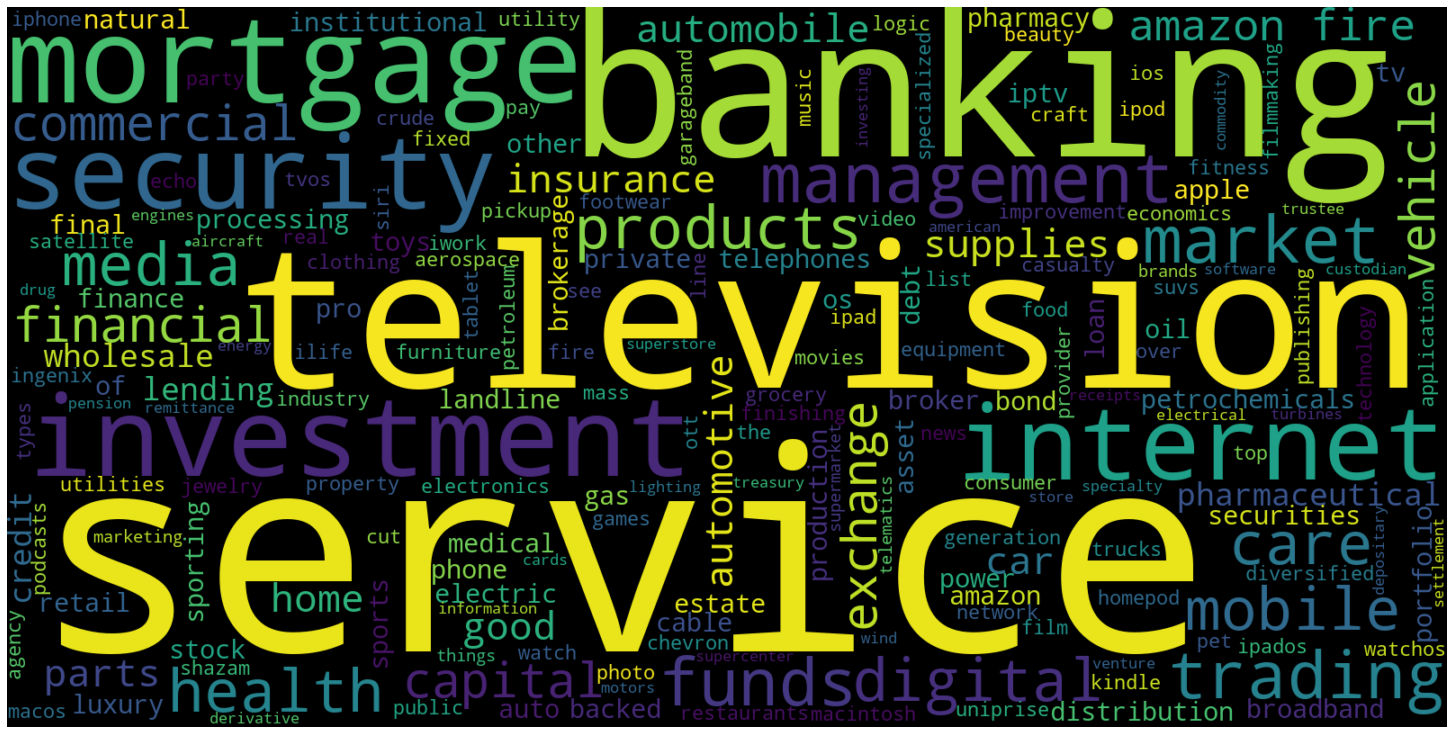

In [15]:
create_wordcloud(products)

### What type of industries do the top 20 company belong from?
---

Similarly, looking at a sample for `industry`,

In [9]:
for i in range(0,5):
    print(wiki_data[i]['industry'])

[[Retail]]
[[Energy industry|Energy]]: [[Oil and gas industry|Oil and gas]]
[[Conglomerate (company)|Conglomerate]]
{{Unbulleted list | [[Computer hardware]] | [[Computer software]] | [[Consumer electronics]] | [[Cloud computing]] | [[Digital distribution]] | [[Fabless manufacturing|Fabless silicon design]] | [[Semiconductors]] | [[Financial technology]] | [[Artificial intelligence]]}}
[[Managed health care]]


We can observe that we need to :
- Extract products from between `[[` and `]]`
- Split and seperate by the delimiter `|`
- Only keep alphanumeric characters, `-` and preserve spaces

Using the same `regex` and `rogue_words` to clean and extract the industries,

In [10]:
industries = []
for i, x in enumerate(wiki_data):
    industry = x['industry'].lower() # get industries and lowercase
    # replace 'and' with '|' and ']]' with empty space 
    industry = industry.replace(' and ', '|').replace(']]', '')
    # extract all industries
    industry = regex.findall(industry)
    # strip trailing and leading spaces
    industry = [i.strip() for i in industry]
    # filter rogue words and de-duplicate
    industry = list(set([i for i in industry if i not in rogue_words]))
    # add to data
    data[i]['industry'] = ', '.join(industry)
    # add to list of industries
    industries.extend(industry)
    
print(industries)

['retail', 'gas industry', 'gas', 'energy', 'energy industry', 'oil', 'conglomerate', 'company', 'artificial intelligence', 'cloud computing', 'digital distribution', 'computer software', 'financial technology', 'computer hardware', 'semiconductors', 'consumer electronics', 'fabless manufacturing', 'fabless silicon design', 'managed health care', 'healthcare', 'health care', 'retail', 'artificial intelligence', 'e-commerce', 'cloud computing', 'digital distribution', 'consumer electronics', 'grocery stores', 'technology', 'entertainment', 'mass media', 'technology company', 'telecommunications industry', 'telecommunications', 'automotive', 'automotive industry', 'automotive', 'automotive industry', 'pharmaceutical', 'gas', 'gas industry', 'oil', 'pharmaceuticals', 'retail', 'telecommunications industry', 'telecommunications', 'mass media', 'retail', 'conglomerate', 'company', 'pharmaceutical', 'retail', 'financial services', 'banking']


Just as before let's create a wordcloud for `industry`,

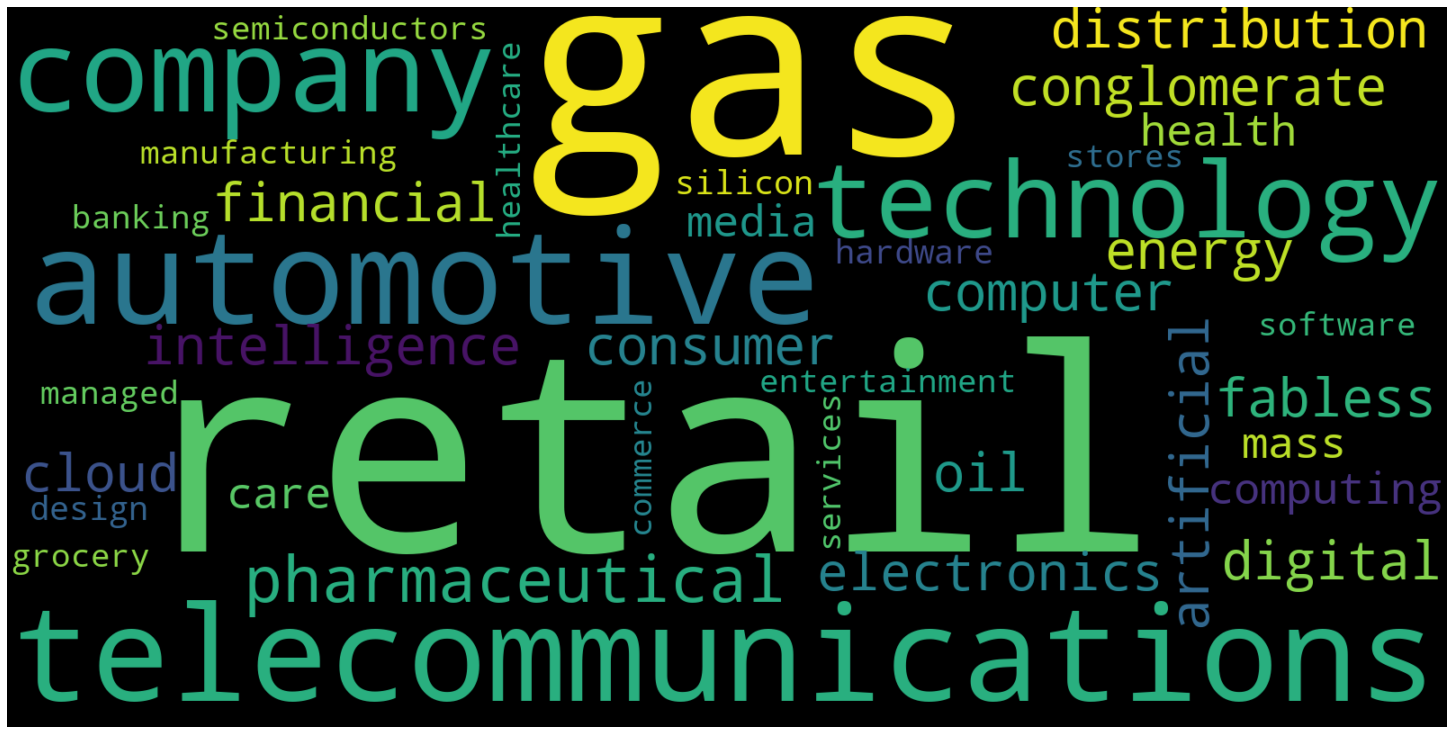

In [27]:
create_wordcloud(industries, ['industry']) # adding "industry" to the stopword list 

### What the assets of the top 20 companies look like?
---

Taking a look at a sample of `assets` below,

In [11]:
for i in range(0,len(wiki_data)):
    print(wiki_data[i]['assets'])

{{increase}} {{US$|219.295 billion}} (2019)
{{Nowrap|Decrease| |US$|346.2 billion|ref| name="201310K"}} {{Decrease}} {{US$|346.2 billion}}
{{increase}} US$707.8 billion (2018)
{{Decrease}} {{US$|338.516&nbsp;billion}}
{{increase}} $173.889 billion (2019)
{{nowrap|increase| |US$|60.381 billion| |small|(2018)|ref| name=FY}} {{increase}} {{US$|60.381 billion}} {{small|(2018)}}
{{increase}} {{US$|196.456 billion}}
{{decrease}} {{US$|162.648 billion}}
{{increase}} {{US$|link|=|yes}} 531 billion     (2018)
{{increase}} US$227.339 billion {{small|(2018)}}
{{decrease}} {{US$|256.54 billion}} {{small|(2018)}}
{{increase}} {{US$|37.66 billion}} (2018)
{{decrease}} {{US$|253.9 billion}} {{small|(2018)}}
{{increase}} US$39.95 billion {{small|(2018)}}
{{increase}} US$45.40 billion
{{increase}} {{US$|264.82 billion}}
{{increase}} {{US$|38.11 billion}} (2019)
{{nowrap|Decrease| US$ 309.129 billion |small|(2018)}} {{Decrease}} US$ 309.129 billion {{small|(2018)}}
{{decrease}} {{US$|67.59 billion}}
{{i

We would need to :  

- Extract both numbers and the unit i.e. `billion` or `trillion`  
- Keep only the monetary values (discard year)

We can also observe that the asset value always appears first and then the year follows.

Defining a simple regular expression for the same,

In [12]:
regex1 = re.compile('([\d\.]+)')

Regex breakdown :

- `([\d\.]+)`: matches and captures one or more `(+)` numbers `(0-9)` with decimal `(.)`.

In [13]:
regex2 = re.compile('(billion|trillion)')

Regex breakdown :

- `(billion|trillion)`: matches and captures either `billion` or `trillion`

In [14]:
assets = []
for i, x in enumerate(wiki_data):
    y = x['assets'] # get assets
    z = regex1.findall(y)[0] # extract assets
    unit = regex2.findall(y)[0] # extract the unit
    asset = float(z) # convert to the numeric
    data[i]['assets'] = str(asset) + ' ' + unit # add to data
    # add to list of assets
    assets.append({'company' : x['company_name'], 'value' : asset, 'unit' : unit})

assets

[{'company': 'Walmart', 'value': 219.295, 'unit': 'billion'},
 {'company': 'ExxonMobil', 'value': 346.2, 'unit': 'billion'},
 {'company': 'Berkshire Hathaway', 'value': 707.8, 'unit': 'billion'},
 {'company': 'Apple Inc.', 'value': 338.516, 'unit': 'billion'},
 {'company': 'UnitedHealth Group', 'value': 173.889, 'unit': 'billion'},
 {'company': 'McKesson Corporation', 'value': 60.381, 'unit': 'billion'},
 {'company': 'CVS Health', 'value': 196.456, 'unit': 'billion'},
 {'company': 'Amazon (company)', 'value': 162.648, 'unit': 'billion'},
 {'company': 'AT&T', 'value': 531.0, 'unit': 'billion'},
 {'company': 'General Motors', 'value': 227.339, 'unit': 'billion'},
 {'company': 'Ford Motor Company', 'value': 256.54, 'unit': 'billion'},
 {'company': 'AmerisourceBergen', 'value': 37.66, 'unit': 'billion'},
 {'company': 'Chevron Corporation', 'value': 253.9, 'unit': 'billion'},
 {'company': 'Cardinal Health', 'value': 39.95, 'unit': 'billion'},
 {'company': 'Costco', 'value': 45.4, 'unit': 'b

Since we have both `billion` as well as `trillion`, let's normalize all the values,

In [15]:
for i, asset in enumerate(assets):
    if asset['unit'] == 'trillion': # if unit is in trillion
        assets[i]['value'] = asset['value'] * 1000 # convert trillion to billion
        assets[i]['unit'] = 'billion'

And create a new dataframe from the same,

In [16]:
df_assets = pd.DataFrame(assets)
df_assets

|    | company                  |    value | unit    |
|---:|:-------------------------|---------:|:--------|
|  0 | Walmart                  |  219.295 | billion |
|  1 | ExxonMobil               |  346.2   | billion |
|  2 | Berkshire Hathaway       |  707.8   | billion |
|  3 | Apple Inc.               |  338.516 | billion |
|  4 | UnitedHealth Group       |  173.889 | billion |
|  5 | McKesson Corporation     |   60.381 | billion |
|  6 | CVS Health               |  196.456 | billion |
|  7 | Amazon (company)         |  162.648 | billion |
|  8 | AT&T                     |  531     | billion |
|  9 | General Motors           |  227.339 | billion |
| 10 | Ford Motor Company       |  256.54  | billion |
| 11 | AmerisourceBergen        |   37.66  | billion |
| 12 | Chevron Corporation      |  253.9   | billion |
| 13 | Cardinal Health          |   39.95  | billion |
| 14 | Costco                   |   45.4   | billion |
| 15 | Verizon Communications   |  264.82  | billion |
| 16 | Kroger                   |   38.11  | billion |
| 17 | General Electric         |  309.129 | billion |
| 18 | Walgreens Boots Alliance |   67.59  | billion |
| 19 | JPMorgan Chase           | 2687     | billion |


Now finally let's create a bar plot showcasing the assets from all the companies,

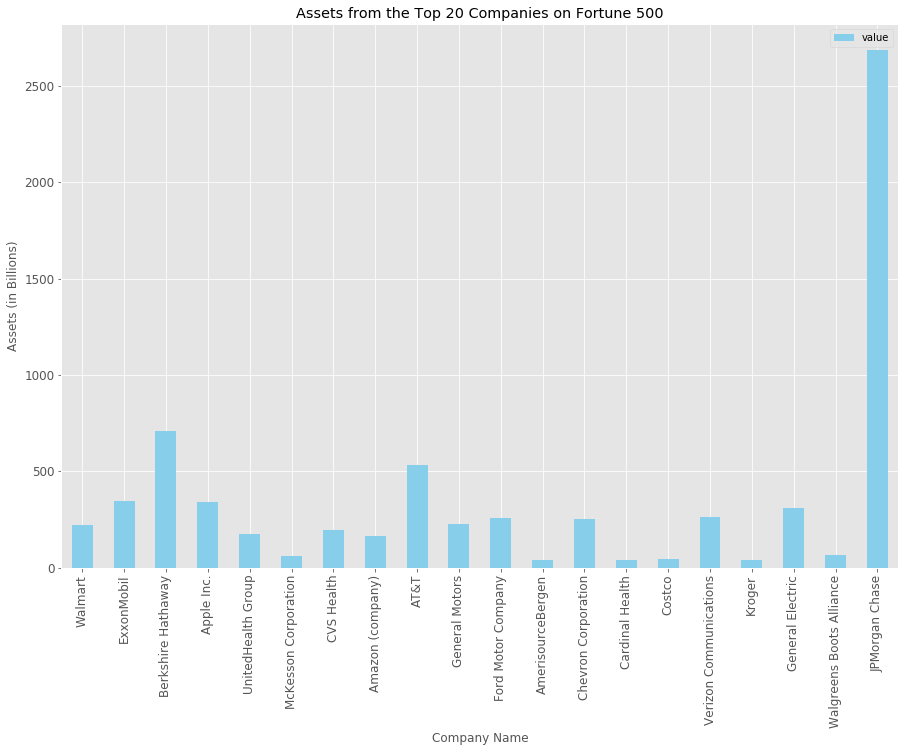

In [51]:
ax = df_assets.plot(kind='bar', 
               title ="Assets from the Top 20 Companies on Fortune 500",
               color='skyblue',
               figsize=(15, 10), 
               legend=True, 
               fontsize=12
              )

ax.set_xticklabels(df_assets.company)
ax.set_xlabel("Company Name", fontsize=12)
ax.set_ylabel("Assets (in Billions)", fontsize=12)
plt.show()

Now let's create a new dataframe containing data related to `products`, `industry` and `assets` as follows,

In [17]:
df_wiki = pd.DataFrame(data)
df_wiki.head()

|    | wiki_title         | product                                                                                                                                                                                                                                                                                                   | industry                                                                                                                                                                                                        | assets          |
|---:|:-------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------|
|  0 | Walmart            | pet supplies, party supplies, clothing, footwear, photo finishing, fitness, auto, grocery, electronics, home, movies, sporting goods, toys, beauty, jewelry, craft supplies, home improvement, music, furniture, health                                                                                   | retail                                                                                                                                                                                                          | 219.295 billion |
|  1 | ExxonMobil         | petrochemicals, crude oil, oil products, natural gas, power generation                                                                                                                                                                                                                                    | gas, energy, oil, energy industry, gas industry                                                                                                                                                                 | 346.2 billion   |
|  2 | Berkshire Hathaway | food processing, casualty insurance, property, mass media, media, aerospace, insurance, final good, utilities, real estate, automotive industry, consumer products, internet, public utility, restaurants, sports equipment, sporting goods, toys, types, diversified investments, investment, automotive | company, conglomerate                                                                                                                                                                                           | 707.8 billion   |
|  3 | Apple Inc.         | siri, iphone, watchos, tvos, shazam, ilife, iwork, final cut pro, ipod, application, apple watch, ipad, logic pro, macintosh, homepod, apple tv, macos, garageband, ios, ipados                                                                                                                           | fabless manufacturing, cloud computing, semiconductors, artificial intelligence, fabless silicon design, consumer electronics, computer software, financial technology, digital distribution, computer hardware | 338.516 billion |
|  4 | UnitedHealth Group | health care, uniprise, service, specialized care services, ingenix, economics, services                                                                                                                                                                                                                   | managed health care                                                                                                                                                                                             | 173.889 billion |


And finally let's combine the datasets from Section 2 and 3 as follows,

In [18]:
# If you dont have the file, you can use the below code to fetch it:
import urllib.request
url = 'https://raw.githubusercontent.com/MonashDataFluency/python-web-scraping/master/data/fortune_500_companies.csv'
urllib.request.urlretrieve(url, 'fortune_500_companies.csv')

('fortune_500_companies.csv', <http.client.HTTPMessage at 0x7fa6743ebc40>)

In [29]:
df = pd.read_csv('fortune_500_companies.csv', nrows=20) # reading only the first 20 rows
df = pd.concat([df, df_wiki], axis=1) # concatenating both the datasets
df

|    |   rank | company_name             | company_website                       | wiki_title               | product                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | industry                                                                                                                                                                                                        | assets          |
|---:|-------:|:-------------------------|:--------------------------------------|:-------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:----------------|
|  0 |      1 | Walmart                  | http://www.stock.walmart.com          | Walmart                  | beauty, footwear, furniture, party supplies, auto, fitness, pet supplies, movies, electronics, jewelry, craft supplies, clothing, grocery, music, photo finishing, home improvement, home, toys, sporting goods, health                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | retail                                                                                                                                                                                                          | 219.295 billion |
|  1 |      2 | Exxon Mobil              | http://www.exxonmobil.com             | ExxonMobil               | oil products, petrochemicals, crude oil, power generation, natural gas                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | gas industry, gas, energy, energy industry, oil                                                                                                                                                                 | 346.2 billion   |
|  2 |      3 | Berkshire Hathaway       | http://www.berkshirehathaway.com      | Berkshire Hathaway       | diversified investments, mass media, automotive industry, media, final good, internet, food processing, public utility, sports equipment, insurance, investment, restaurants, casualty insurance, real estate, types, aerospace, automotive, consumer products, property, utilities, toys, sporting goods                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | conglomerate, company                                                                                                                                                                                           | 707.8 billion   |
|  3 |      4 | Apple                    | http://www.apple.com                  | Apple Inc.               | ipad, apple tv, ilife, application, ipados, siri, ios, shazam, iwork, ipod, homepod, macintosh, tvos, logic pro, garageband, watchos, apple watch, macos, iphone, final cut pro                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | artificial intelligence, cloud computing, digital distribution, computer software, financial technology, computer hardware, semiconductors, consumer electronics, fabless manufacturing, fabless silicon design | 338.516 billion |
|  4 |      5 | UnitedHealth Group       | http://www.unitedhealthgroup.com      | UnitedHealth Group       | ingenix, service, specialized care services, uniprise, health care, economics, services                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | managed health care                                                                                                                                                                                             | 173.889 billion |
|  5 |      6 | McKesson                 | http://www.mckesson.com               | McKesson Corporation     | pharmaceuticals, medical technology, health care services                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     | healthcare                                                                                                                                                                                                      | 60.381 billion  |
|  6 |      7 | CVS Health               | http://www.cvshealth.com              | CVS Health               |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | health care, retail                                                                                                                                                                                             | 196.456 billion |
|  7 |      8 | Amazon.com               | http://www.amazon.com                 | Amazon (company)         | amazon fire os, fire os, amazon fire tablet, amazon kindle, amazon fire tv, amazon fire, amazon echo                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | artificial intelligence, e-commerce, cloud computing, digital distribution, consumer electronics, grocery stores                                                                                                | 162.648 billion |
|  8 |      9 | AT&T                     | http://www.att.com                    | AT&T                     | film production, sports management, video games, landline, podcasts, publishing, pay television, satellite television, television production, internet service provider, network security, iptv, cable television, fixed-line telephones, ott services, mobile telephones, internet services, digital television, mobile phone, news agency, home security, over-the-top media services, broadband, filmmaking                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                | technology, entertainment, mass media, technology company, telecommunications industry, telecommunications                                                                                                      | 531.0 billion   |
|  9 |     10 | General Motors           | http://www.gm.com                     | General Motors           | automobiles, car, automobile parts, commercial vehicles                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       | automotive, automotive industry                                                                                                                                                                                 | 227.339 billion |
| 10 |     11 | Ford Motor               | http://www.corporate.ford.com         | Ford Motor Company       | automobiles, automotive parts, pickup trucks, car, luxury car, commercial vehicles, list of auto parts, suvs, luxury vehicles, commercial vehicle                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | automotive, automotive industry                                                                                                                                                                                 | 256.54 billion  |
| 11 |     12 | AmerisourceBergen        | http://www.amerisourcebergen.com      | AmerisourceBergen        | pharmacy services, pharmaceuticals                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            | pharmaceutical                                                                                                                                                                                                  | 37.66 billion   |
| 12 |     13 | Chevron                  | http://www.chevron.com                | Chevron Corporation      | other, see chevron products, petrochemicals, marketing brands, petroleum, natural gas                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | gas, gas industry, oil                                                                                                                                                                                          | 253.9 billion   |
| 13 |     14 | Cardinal Health          | http://www.cardinalhealth.com         | Cardinal Health          | pharmaceutical products, medical, services                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    | pharmaceuticals                                                                                                                                                                                                 | 39.95 billion   |
| 14 |     15 | Costco                   | http://www.costco.com                 | Costco                   |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               | retail                                                                                                                                                                                                          | 45.4 billion    |
| 15 |     16 | Verizon                  | http://www.verizon.com                | Verizon Communications   | mobile phone, iptv, telematics, internet, cable television, broadband, internet of things, landline, digital media, digital television                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        | telecommunications industry, telecommunications, mass media                                                                                                                                                     | 264.82 billion  |
| 16 |     17 | Kroger                   | http://www.thekrogerco.com            | Kroger                   | superstore, other specialty, supermarket, supercenter                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | retail                                                                                                                                                                                                          | 38.11 billion   |
| 17 |     18 | General Electric         | http://www.ge.com                     | General Electric         | lighting, finance, wind turbines, electrical distribution, software, aircraft engines, energy, health care, electric power distribution, electric motors                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      | conglomerate, company                                                                                                                                                                                           | 309.129 billion |
| 18 |     19 | Walgreens Boots Alliance | http://www.walgreensbootsalliance.com | Walgreens Boots Alliance | drug store, pharmacy                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          | pharmaceutical, retail                                                                                                                                                                                          | 67.59 billion   |
| 19 |     20 | JPMorgan Chase           | http://www.jpmorganchase.com          | JPMorgan Chase           | broker services, finance, institutional investing, trustee services, currency exchange, debt settlement, financial markets, venture capital, foreign exchange market, loan servicing, mortgage brokers, index funds, investment banking, hedge funds, exchange-traded funds, mortgage-backed security, mortgage, mutual funds, underwriting, stock trading, security, investment management, prime brokerage, mortgage brokering, retail banking, backed securities, mortgage loans, bond, digital banking, merchant services, money market trading, american depositary receipts, financial analysis, credit cards, institutional investor, private equity, commodity market, insurance, capital market services, investment, retail, mobile banking, treasury services, alternative financial services, futures exchange, private banking, portfolios, subprime lending, bond trading, financial capital, custodian banking, commodities trading, risk management, pension funds, estate planning, brokerage, collateralized debt obligations, portfolio, asset management, securities lending, wholesale mortgage lenders, credit default swap, wealth management, remittance, wholesale mortgage lending, wire transfers, investment capital, credit derivative trading, information processing, security services, stock trader, asset allocation, wholesale funding, commercial banking | financial services, banking                                                                                                                                                                                     | 2.687 trillion  |

And export them to a csv file,

In [33]:
df.to_csv('top_20_companies.csv', index=False)

#### Challenge
---
Create a bar chart of `equity` of all the top 20 Fortune 500 companies and find out which has the highest value.

---